# Task 2: Exploratory Data Analysis 

This notebook presents an exploratory data analysis of customer churn data for an energy company. We'll investigate various factors that might influence customer churn and provide insights to guide retention strategies.

## 1. Objectives:
1. Understand the distribution of key variables related to customer churn
2. Explore the relationship between customer tenure and churn probability
3. Investigate correlations between various numeric variables
4. Identify potential factors that might influence a customer's decision to churn

Let's begin by importing necessary libraries and loading our data.

## 2. Import packages

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from scipy.stats import ttest_ind
from scipy.stats import chi2_contingency

from IPython.display import HTML
import base64
from io import BytesIO
from statsmodels.graphics.mosaicplot import mosaic
from collections import defaultdict

from utils import plot_prob_progression
from data_summary import create_summary_table



# Shows plots in jupyter notebook
%matplotlib inline

# Set plot style
sns.set(color_codes=True)

In [3]:
import os 

os.environ['R_HOME'] = 'C:/Program Files/R/R-4.4.1'  

# import rpy2's package module
from rpy2.robjects.packages import importr
from functools import partial
import rpy2.robjects.packages as rpackages
from rpy2.robjects.vectors import StrVector
from rpy2.ipython import html
import rpy2.robjects as robjects #interface r objetcs to python
html.html_rdataframe=partial(html.html_rdataframe, table_class="docutils")

%load_ext rpy2.ipython

d:\DS_Project\BCG_DataScience_VI\.venv\Lib\site-packages\rpy2\robjects\packages.py:367: UserWarning: The symbol 'quartz' is not in this R namespace/package.
  warnings.warn(


In [4]:
%%R 
library(ggplot2)
library(ggstatsplot)
library(dplyr)
library(wesanderson)
library(ggridges)

You can cite this package as:
     Patil, I. (2021). Visualizations with statistical details: The 'ggstatsplot' approach.
     Journal of Open Source Software, 6(61), 3167, doi:10.21105/joss.03167

Attaching package: 'dplyr'

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union



---

## 3. Data Collection and Preprocessing

### 3.1 Data Loading

The analysis uses two main datasets:
1. `client_data.csv`: Contains information about individual customers
2. `price_data.csv`: Includes pricing information

In [5]:
client_df = pd.read_csv('./data/client_data.csv')
price_df = pd.read_csv('./data/price_data.csv')
merged_df = pd.merge(client_df, price_df, on='id')

View the first 3 rows of a dataframe using the `head` method

In [5]:
client_df.head(3)

,id,channel_sales,cons_12m,cons_gas_12m,cons_last_month,date_activ,date_end,date_modif_prod,date_renewal,forecast_cons_12m,...,has_gas,imp_cons,margin_gross_pow_ele,margin_net_pow_ele,nb_prod_act,net_margin,num_years_antig,origin_up,pow_max,churn
0,24011ae4ebbe3035111d65fa7c15bc57,foosdfpfkusacimwkcsosbicdxkicaua,0,54946,0,2013-06-15,2016-06-15,2015-11-01,2015-06-23,0.00,...,t,0.0,25.44,25.44,2,678.99,3,lxidpiddsbxsbosboudacockeimpuepw,43.648,1
1,d29c2c54acc38ff3c0614d0a653813dd,MISSING,4660,0,0,2009-08-21,2016-08-30,2009-08-21,2015-08-31,189.95,...,f,0.0,16.38,16.38,1,18.89,6,kamkkxfxxuwbdslkwifmmcsiusiuosws,13.800,0
2,764c75f661154dac3a6c254cd082ea7d,foosdfpfkusacimwkcsosbicdxkicaua,544,0,0,2010-04-16,2016-04-16,2010-04-16,2015-04-17,47.96,...,f,0.0,28.60,28.60,1,6.60,6,kamkkxfxxuwbdslkwifmmcsiusiuosws,13.856,0


In [6]:
price_df.head(3)

,id,price_date,price_off_peak_var,price_peak_var,price_mid_peak_var,price_off_peak_fix,price_peak_fix,price_mid_peak_fix
0,038af19179925da21a25619c5a24b745,2015-01-01,0.151367,0.0,0.0,44.266931,0.0,0.0
1,038af19179925da21a25619c5a24b745,2015-02-01,0.151367,0.0,0.0,44.266931,0.0,0.0
2,038af19179925da21a25619c5a24b745,2015-03-01,0.151367,0.0,0.0,44.266931,0.0,0.0


---

### 3.2 Data Profiling


To get a comprehensive understanding of our dataset, we'll use a custom function `create_summary_table` from the `data_summary` module. This function provides a detailed summary of each variable in our dataset, including statistics, frequency distributions, and visualizations.


#### 3.2.1 Client data profile

##### Client Data Profile Summary Table

In [13]:
client_df.shape

(14606, 26)

No,Variable,Stats / Values,Freqs (% of Valid),Graph,Missing
1,id[object],563dde550fd624d7352f3de77c0cdfcd: 1 (0.0%)24011ae4ebbe3035111d65fa7c15bc57: 1 (0.0%)d29c2c54acc38ff3c0614d0a653813dd: 1 (0.0%)764c75f661154dac3a6c254cd082ea7d: 1 (0.0%)bba03439a292a1e166f80264c16191cb: 1 (0.0%),1 (0.0%)1 (0.0%)1 (0.0%)1 (0.0%)1 (0.0%),,0 (0.0%)
2,channel_sales[object],foosdfpfkusacimwkcsosbicdxkicaua: 6754 (46.2%)MISSING: 3725 (25.5%)lmkebamcaaclubfxadlmueccxoimlema: 1843 (12.6%)usilxuppasemubllopkaafesmlibmsdf: 1375 (9.4%)ewpakwlliwisiwduibdlfmalxowmwpci: 893 (6.1%),6754 (46.2%)3725 (25.5%)1843 (12.6%)1375 (9.4%)893 (6.1%),,0 (0.0%)
3,cons_12m[int64],Mean (sd): 159220.3 (573465.3)min < med < max: 0.0 < 14115.5 < 6207104.0IQR (CV): 35089.0 (3.6),11065 distinct values,,0 (0.0%)
4,cons_gas_12m[int64],Mean (sd): 28092.4 (162973.1)min < med < max: 0.0 < 0.0 < 4154590.0IQR (CV): 0.0 (5.8),2112 distinct values,,0 (0.0%)
5,cons_last_month[int64],Mean (sd): 16090.3 (64364.2)min < med < max: 0.0 < 792.5 < 771203.0IQR (CV): 3383.0 (4.0),4751 distinct values,,0 (0.0%)
6,date_activ[object],2009-08-01: 95 (0.7%)2010-02-01: 92 (0.6%)2009-09-01: 76 (0.5%)2009-10-01: 55 (0.4%)2010-01-11: 48 (0.3%),95 (0.7%)92 (0.6%)76 (0.5%)55 (0.4%)48 (0.3%),,0 (0.0%)
7,date_end[object],2016-02-01: 145 (1.0%)2016-08-01: 125 (0.9%)2016-09-01: 117 (0.8%)2016-10-05: 115 (0.8%)2016-12-31: 104 (0.7%),145 (1.0%)125 (0.9%)117 (0.8%)115 (0.8%)104 (0.7%),,0 (0.0%)
8,date_modif_prod[object],2015-11-01: 721 (4.9%)2015-05-24: 269 (1.8%)2015-12-17: 199 (1.4%)2015-09-20: 173 (1.2%)2015-12-16: 172 (1.2%),721 (4.9%)269 (1.8%)199 (1.4%)173 (1.2%)172 (1.2%),,0 (0.0%)
9,date_renewal[object],2015-06-23: 587 (4.0%)2015-03-09: 451 (3.1%)2015-02-09: 273 (1.9%)2015-07-04: 265 (1.8%)2015-10-11: 231 (1.6%),587 (4.0%)451 (3.1%)273 (1.9%)265 (1.8%)231 (1.6%),,0 (0.0%)
10,forecast_cons_12m[float64],Mean (sd): 1868.6 (2387.6)min < med < max: 0.0 < 1112.9 < 82902.8IQR (CV): 1906.8 (1.3),13993 distinct values,,0 (0.0%)

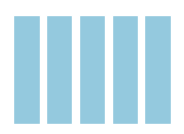
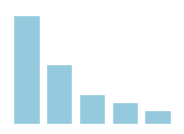
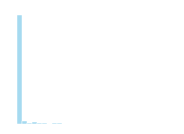
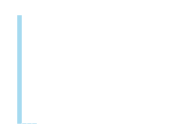
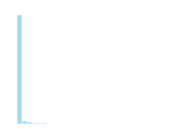
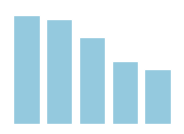
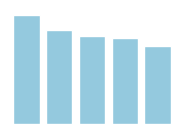
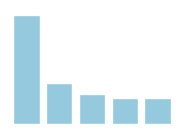
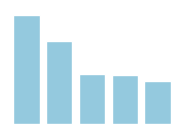
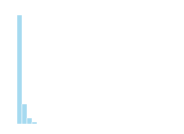
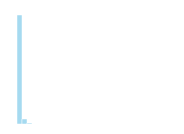
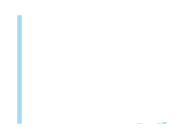
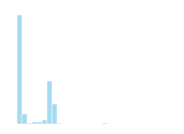
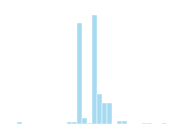
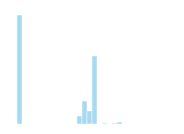
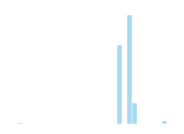
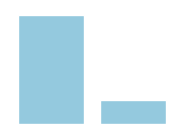
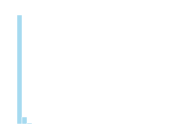
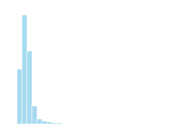
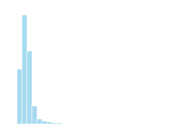
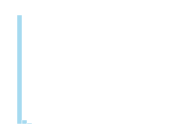
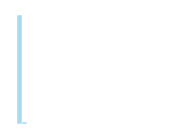
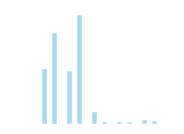
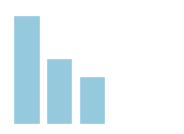
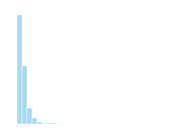
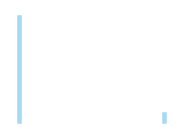

In [5]:
client_df_summary_table = create_summary_table(client_df)
display(client_df_summary_table)

##### Key Observations and Actions from Client Data

1. **Missing Values:**
   - **Observation:** Most variables have no missing data, but `channel_sales` (25.5%) and `origin_up` (0.4%) have missing values.
   - **Action:** Handle missing data by imputing values (e.g., mode for `origin_up`) or creating a separate category for missing `channel_sales` during EDA.

2. **Churn Imbalance:**
   - **Observation:** The `churn` variable is imbalanced, with a 10% churn rate.
   - **Action:** Visualize churn distribution and consider balancing techniques (e.g., stratified sampling) in subsequent modeling steps.

3. **Customer Tenure:**
   - **Observation:** `num_years_antig` (customer tenure) spans from 1 to 13 years.
   - **Action:** Analyze tenure distribution and segment customers based on tenure for detailed churn analysis.

4. **Consumption Data Range:**
   - **Observation:** Consumption variables exhibit a wide range, suggesting potential outliers.
   - **Action:** Visualize the data distribution (e.g., boxplots) to identify and address outliers.

5. **Identical Forecast Variables:**
   - **Observation:** `forecast_cons_12m` and `forecast_cons_year` are identical.
   - **Action:** Drop one of these variables to simplify analysis.

6. **Discount and Energy Price Correlation:**
   - **Observation:** Negative correlation between `forecast_discount_energy` and `forecast_price_energy_peak`.
   - **Action:** Explore this relationship further to understand its implications for energy pricing trends.

7. **Off-Peak Price Correlation:**
   - **Observation:** Positive correlation between `forecast_price_energy_off_peak` and `forecast_price_pow_off_peak`.
   - **Action:** Visualize and decide whether to drop one variable or create interaction terms if necessary.

8. **Outliers in Numerical Variables:**
   - **Observation:** Numerical variables display potential outliers.
   - **Action:** Detect outliers through visualization and consider transformation techniques like logarithmic scaling to mitigate their impact on analysis.

9. **Time Variable Formatting:**
   - **Observation:** Date-related variables are stored as object types.
   - **Action:** Convert these variables to datetime format for accurate time-based analysis and trend exploration.
   
10. **Low Frequency Values:**
   - **Observation**: There is an indication of the presence of low frequency values in the `sales_channels` and `num_years_antig`.
   - **Action**: 
      - For `sales_channel`, group the low frequency values into a single category called "OTHER".
      - For `num_years_antig`, group the low frequency values by quantiles.


In [7]:
def save_summary_table_to_html(summary_table, file_path='./summary_table.html'):
    html_content = summary_table.data

    # Save the HTML content to a file
    with open(file_path, 'w', encoding='utf-8') as file:
        file.write(html_content)

    print(f"HTML file saved successfully at {file_path}.")

In [8]:
save_summary_table_to_html(client_df_summary_table, './images/client_df_summary_table.html')

HTML file saved successfully at ./images/client_df_summary_table.html.


#### Price Data profile

##### Key Observations and Actions from Price Data

1. **Data Quality:**
   - **Observation:** No missing values.
   - **Action:** No data cleaning required for missing values.

2. **Low Price Variability:**
   - **Observation:** 'price_off_peak_var', 'price_peak_var', and 'price_mid_peak_var' show low variability, indicating consistent pricing.
   - **Action:** Retain these variables but be cautious when interpreting results due to their low variation.

3. **Fixed Price Variation:**
   - **Observation:** 'price_off_peak_fix', 'price_peak_fix', and 'price_mid_peak_fix' exhibit more variation.
   - **Action:** Visualize the distribution of fixed prices and assess potential outliers.

4. **Time Variable Formatting:**
   - **Observation:** 'price_date' is an object type.
   - **Action:** Convert 'price_date' to datetime format for proper time-based analysis and trend exploration.

No,Variable,Stats / Values,Freqs (% of Valid),Graph,Missing
1,id[object],c18b6305122e4976739b8420d5b54ec5: 12 (0.0%)e4053a0ad6c55e4665e8e9adb9f75db5: 12 (0.0%)1221993f581c1b335d231e247028d40d: 12 (0.0%)2dc2c9a9f6e6896d9a07d7bcbb9d0ce9: 12 (0.0%)762cab733464cae4ce1d452ce84cb94b: 12 (0.0%),12 (0.0%)12 (0.0%)12 (0.0%)12 (0.0%)12 (0.0%),,0 (0.0%)
2,price_date[object],2015-12-01: 16094 (8.3%)2015-08-01: 16094 (8.3%)2015-07-01: 16090 (8.3%)2015-11-01: 16087 (8.3%)2015-10-01: 16085 (8.3%),16094 (8.3%)16094 (8.3%)16090 (8.3%)16087 (8.3%)16085 (8.3%),,0 (0.0%)
3,price_off_peak_var[float64],Mean (sd): 0.1 (0.0)min < med < max: 0.0 < 0.1 < 0.3IQR (CV): 0.0 (0.2),1853 distinct values,,0 (0.0%)
4,price_peak_var[float64],Mean (sd): 0.1 (0.0)min < med < max: 0.0 < 0.1 < 0.2IQR (CV): 0.1 (0.9),1189 distinct values,,0 (0.0%)
5,price_mid_peak_var[float64],Mean (sd): 0.0 (0.0)min < med < max: 0.0 < 0.0 < 0.1IQR (CV): 0.1 (1.2),711 distinct values,,0 (0.0%)
6,price_off_peak_fix[float64],Mean (sd): 43.3 (5.4)min < med < max: 0.0 < 44.3 < 59.4IQR (CV): 3.7 (0.1),66 distinct values,,0 (0.0%)
7,price_peak_fix[float64],Mean (sd): 10.6 (12.8)min < med < max: 0.0 < 0.0 < 36.5IQR (CV): 24.3 (1.2),31 distinct values,,0 (0.0%)
8,price_mid_peak_fix[float64],Mean (sd): 6.4 (7.8)min < med < max: 0.0 < 0.0 < 17.5IQR (CV): 16.2 (1.2),28 distinct values,,0 (0.0%)

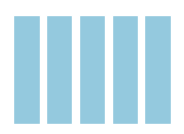
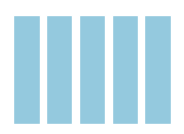
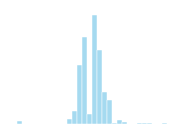
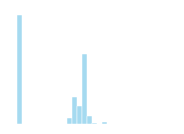
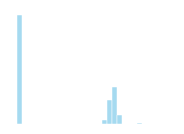
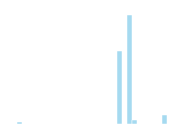
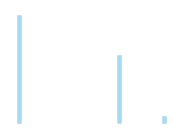
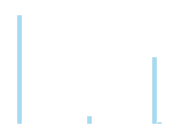

In [22]:
price_df_summary_table = create_summary_table(price_df)
display(price_df_summary_table)

In [25]:
save_summary_table_to_html(price_df_summary_table, './images/price_df_summary_table.html')

HTML file saved successfully at ./images/price_df_summary_table.html.


### 4. Data Preprocessing and Cleaning

#### 4.1 Adjusting the data type of date related variables


In [6]:
def convert_dates_client_data(df):
    date_columns = ['date_activ', 'date_end', 'date_modif_prod', 'date_renewal']
    for column in date_columns:
        df[column] = pd.to_datetime(df[column])

# Convert date related variables to datetime data type for client_df
convert_dates_client_data(client_df)

def convert_dates_price_data(df):
    date_columns = ['price_date']
    for column in date_columns:
        df[column] = pd.to_datetime(df[column])

# Convert date related variables to datetime data type for price_df
convert_dates_price_data(price_df)

#### 4.2 Simplify channel_sales values


In [7]:
# Simplify channel_sales values excluding "MISSING"
channel_sales_mapping = {channel: f'Channel_{i}' for i, channel in enumerate(client_df[client_df['channel_sales'] != 'MISSING']['channel_sales'].unique())}
client_df['channel_sales'] = client_df['channel_sales'].map(channel_sales_mapping)


#### 4.3 Missing Values

##### Investigating Missing Values

In this section, we'll walk through our analysis of missing values in the channel_sales variable and its relationship to customer churn

In previous section, we already learned that channel_sales and origin_up have missing values. Now, let's see if there is a relationship between missing values in channel_sales and churn.


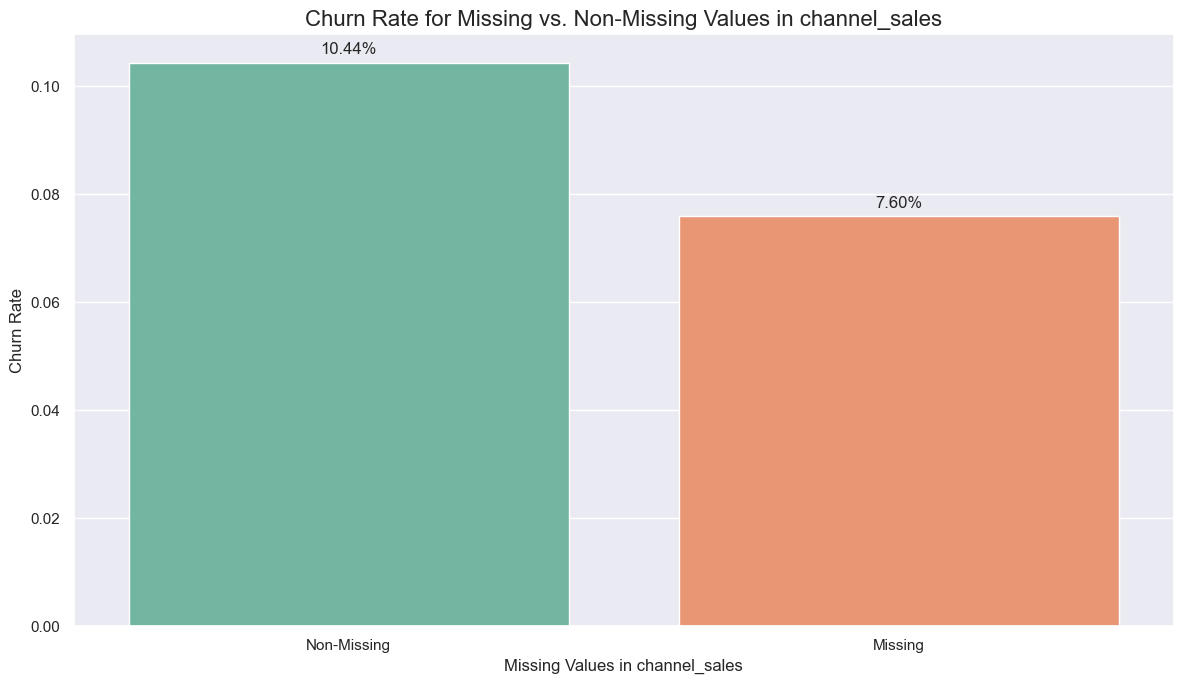

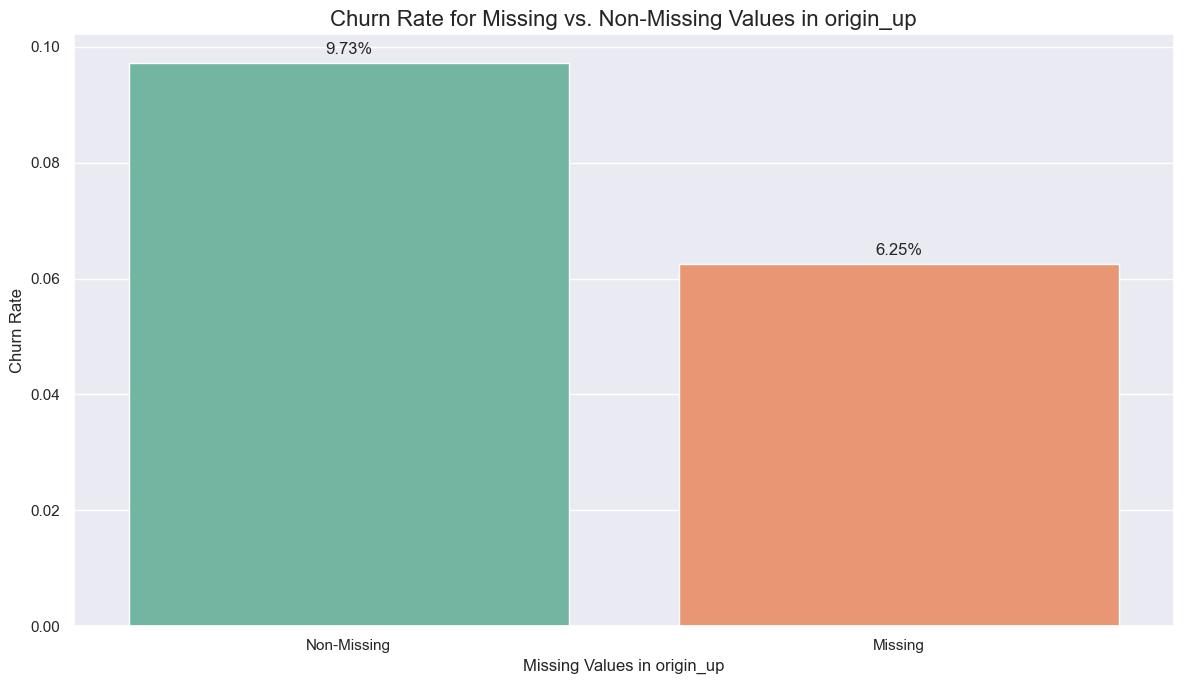

In [63]:
def plot_churn_rate_analysis(client_df, column_name):
    # Create a contingency table
    contingency_table = pd.crosstab(client_df[column_name].isnull(), client_df['churn'])

    plt.figure(figsize=(12, 7))

    # Calculate churn rates and their standard errors
    churn_rates = contingency_table[1] / contingency_table.sum(axis=1)
    n_samples = contingency_table.sum(axis=1)
    std_errors = np.sqrt(churn_rates * (1 - churn_rates) / n_samples)

    # Create the bar plot
    ax = sns.barplot(x=contingency_table.index, y=churn_rates, 
                     errorbar=('ci', 95), capsize=0.1, 
                     palette="Set2", hue=contingency_table.index, legend=False)

    # Add value labels on top of each bar
    for i, v in enumerate(churn_rates):
        ax.text(i, v + 0.001, f'{v:.2%}', ha='center', va='bottom')

    # Customize the plot
    plt.title(f"Churn Rate for Missing vs. Non-Missing Values in {column_name}", fontsize=16)
    plt.xlabel(f"Missing Values in {column_name}", fontsize=12)
    plt.ylabel("Churn Rate", fontsize=12)
    plt.xticks([0, 1], ["Non-Missing", "Missing"])

    # # Add sample size information
    # for i, (index, row) in enumerate(contingency_table.iterrows()):
    #     total = row.sum()
    #     plt.text(i, 0.01, f'n = {total}', ha='center', va='bottom', color='black')

    # # Add a descriptive text box with different statistical results for each variable
    # if column_name == 'channel_sales':
    #     textstr = '\n'.join((
    #         r'$\chi^2$ = 25.25',
    #         r'p = 0.0000',
    #         r"Cramer's V = 0.0416"
    #     ))
    # elif column_name == 'origin_up':
    #     textstr = '\n'.join((
    #         r'$\chi^2$ = 15.75',
    #         r'p = 0.0001',
    #         r"Cramer's V = 0.0352"
    #     ))
    
    # props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    # plt.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=10,
    #          verticalalignment='top', bbox=props)

    plt.tight_layout()
    plt.show()

# Apply the function on channel_sales and origin_up
plot_churn_rate_analysis(client_df, 'channel_sales')
plot_churn_rate_analysis(client_df, 'origin_up')

**Observation**:
- For channel_sales the churn rate is lower when channel_sales data is missing. This is contrary warrants further investigation.
- For origin_up, similar to channel_sales, the churn rate is lower when origin_up is missing, though the difference is less pronounced.

Let's conduct a chi-square test to determine if the relationship between missing values in channel_sales and churn is statistically significant. 
- The null hypothesis (H0) states that there is no association between missing values in the channel_sales variable and the churn outcome. 
- The alternative hypothesis (H1) posits that there is a significant association. 
- A p-value less than the significance level (typically 0.05) will lead us to reject the null hypothesis, indicating a potential impact of missing values on churn.

Additionally, we will calculate Cramer's V to assess the strength of the association:
- Cramer's V ranges from 0 to 1, where values closer to 0 indicate a weak association and values closer to 1 indicate a strong association.


In [59]:
def analyze_missing_values_impact(df, column_name):
    # Create a contingency table
    contingency_table = pd.crosstab(df[column_name].isnull(), df['churn'])
    # Perform chi-square test
    chi2, p_value, dof, expected = chi2_contingency(contingency_table)

    print("Chi-square test results:")
    print(f"Chi-square statistic: {chi2:.4f}")
    print(f"p-value: {p_value:.4f}")

    # Interpret the results
    alpha = 0.05
    if p_value < alpha:
        print(f"There is a significant relationship between missing values in {column_name} and churn.")
    else:
        print(f"There is no significant relationship between missing values in {column_name} and churn.")

    n = contingency_table.sum().sum()
    min_dim = max(min(contingency_table.shape) - 1, 1)  # Ensure min_dim is at least 1
    cramer_v = np.sqrt(chi2 / (n * min_dim)) 

    print(f"\nEffect size (Cramer's V): {cramer_v:.4f}")

    # Interpret effect size
    if cramer_v < 0.1:
        effect_size = "negligible"
    elif cramer_v < 0.3:
        effect_size = "small"
    elif cramer_v < 0.5:
        effect_size = "medium"
    else:
        effect_size = "large"

    print(f"The effect size is {effect_size}.")
    # Conclusion
    print("\nConclusion:")
    if p_value < alpha:
        if cramer_v < 0.1:
            print(f"Although statistically significant, the relationship between missing values in {column_name} and churn is negligible in practical terms.")
        else:
            print(f"Removing missing values in {column_name} might significantly impact the churn analysis.")
    else:
        print(f"Removing missing values in {column_name} is unlikely to significantly impact the churn analysis.")

In [60]:
# Apply the function on channel_sales and origin_up
analyze_missing_values_impact(client_df, 'channel_sales')

Chi-square test results:
Chi-square statistic: 25.2464
p-value: 0.0000
There is a significant relationship between missing values in channel_sales and churn.

Effect size (Cramer's V): 0.0416
The effect size is negligible.

Conclusion:
Although statistically significant, the relationship between missing values in channel_sales and churn is negligible in practical terms.


In [61]:
analyze_missing_values_impact(client_df, 'origin_up')

Chi-square test results:
Chi-square statistic: 0.5279
p-value: 0.4675
There is no significant relationship between missing values in origin_up and churn.

Effect size (Cramer's V): 0.0060
The effect size is negligible.

Conclusion:
Removing missing values in origin_up is unlikely to significantly impact the churn analysis.


**Statistical Test Results**:

**Channel Sales**:
- The relationship between channel_sales and churn is statistically detectable, but practically insignificant: There's a tiny, measurable connection between missing 'channel_sales' data and churn. However, this connection is so weak that it won't affect our ability to understand or predict churn.
- Implication for handling missing data: We can likely fill in these missing 'channel_sales' values using a simple method (like the most frequent category or an 'Unknown' category) without skewing our churn analysis.

**Origin Up**:
- No connection to churn: Missing data in the 'origin_up' field has no relationship with whether a customer churns.
- Implication for handling missing data: We can safely ignore the missing 'origin_up' data points or use a simple imputation strategy, as they won't influence our churn insights.

##### Handling Missing Values


In [8]:
# Decide on handling strategy based on analysis
# fill missing values with a placeholder
client_df['channel_sales'] = client_df['channel_sales'].fillna('Unknown')
client_df['origin_up'] = client_df['origin_up'].fillna('Unknown')

print("\nMissing values after handling:")
print(client_df[['channel_sales', 'origin_up']].isnull().sum())


Missing values after handling:
channel_sales    0
origin_up        0
dtype: int64


#### 4.4 Handling Sparse Variables

##### 4.4.1 Grouping Low-Frequency Sales Channels


On the summary table, there is an indication of the presence of low frequency sales channels. Let's investigate this further. Below is the value counts of the channel_sales variable:

In [73]:
client_df['channel_sales'].value_counts()

channel_sales
Channel_0    6754
Unknown      3725
Channel_1    1843
Channel_2    1375
Channel_3     893
Channel_5      11
Channel_4       3
Channel_6       2
Name: count, dtype: int64

The above table shows that there are 6 sales channels with less than 11 customers. Let's group these low-frequency sales channels into a single category called "OTHER".

In [9]:
def categorize_low_counts(df, column_name, threshold=11, other_label='OTHER'):
    """Categorizes values in a DataFrame column with counts below a threshold.

    Args:
        df (pd.DataFrame): The DataFrame to work with.
        column_name (str): The name of the column to categorize.
        threshold (int, optional): Count threshold for grouping. Defaults to 11.
        other_label (str, optional): Label to use for grouped values. Defaults to 'OTHER'.

    Returns:
        pd.Series: A Series representing the categorized column.
    """

    value_counts = df[column_name].value_counts()
    common_values = value_counts[value_counts > threshold].index
    df[column_name] = df[column_name].where(df[column_name].isin(common_values), other_label)
    return df[column_name]

In [10]:
client_df['channel_sales'] = categorize_low_counts(client_df, 'channel_sales', threshold=11)
client_df['channel_sales'].value_counts()

channel_sales
Channel_0    6754
Unknown      3725
Channel_1    1843
Channel_2    1375
Channel_3     893
OTHER          16
Name: count, dtype: int64

##### 4.4.2 Grouping Client Antiquity by Quantiles

The distribution of 'num_years_antig' is characterized by sparsity, where certain values occur significantly less frequently than others. This can lead to challenges in analysis and modeling, as low-frequency categories may not provide enough data for reliable insights. 

To address this issue, we will group the values into quantiles. This approach allows us to create a more balanced representation of the data, ensuring that each group contains a sufficient number of observations. By doing so, we can enhance the robustness of our analysis and improve the interpretability of the results.

In [11]:
client_df['num_years_antig_grp'] = pd.qcut(client_df['num_years_antig'], q=4, labels=None)

In [12]:
client_df['num_years_antig_grp'].value_counts()

num_years_antig_grp
(0.999, 4.0]    6427
(5.0, 6.0]      4769
(4.0, 5.0]      2317
(6.0, 13.0]     1093
Name: count, dtype: int64

### 4.6 Outliers

#### 4.6.1 Investigating outliers frequency and their impact on churn

In this section, we conduct a comprehensive analysis of outliers in our dataset and their potential impact on customer churn. Outliers, being extreme values that deviate significantly from other observations, can sometimes provide valuable insights into customer behavior or indicate data quality issues that need addressing.

Our analysis focuses on two key aspects:

1. The prevalence of outliers in each feature, quantified as a percentage of the total observations.
2. The difference in churn rates between outliers and non-outliers for each feature.

By examining these aspects, we aim to:
- Identify which features are most prone to outliers
- Understand how outliers in different features correlate with customer churn
- Prioritize our data cleaning and feature engineering efforts based on the impact of outliers on churn prediction



These insights will guide our subsequent steps in data preprocessing and model development, ensuring we focus our efforts on the most impactful features for predicting and preventing customer churn.

In [32]:
# Define numerical columns for outlier analysis
numerical_columns = ['cons_12m', 'cons_gas_12m', 'cons_last_month', 'forecast_cons_12m', 
                     'imp_cons', 'margin_gross_pow_ele', 'margin_net_pow_ele', 'net_margin', 'pow_max']

# Function to calculate IQR and identify outliers
def identify_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    return outliers, lower_bound, upper_bound

outlier_results = []

# Analyze outliers for each numerical column
for column in numerical_columns:
    outliers, lower_bound, upper_bound = identify_outliers(client_df, column)
    
    # Analyze relationship between outliers and churn
    outlier_churn_rate = outliers['churn'].mean()
    overall_churn_rate = client_df['churn'].mean()
    

    # Append the results to the list
    outlier_results.append({
        'Feature': column,
        'Num_Outliers': len(outliers),
        'Pct_Outliers': (len(outliers) / len(client_df)) * 100,
        'Lower_Bound': lower_bound,
        'Upper_Bound': upper_bound,
        'Min_Value': client_df[column].min(),
        'Max_Value': client_df[column].max(),
        'Outlier_Churn_Rate': outlier_churn_rate,
        'Overall_Churn_Rate': overall_churn_rate,
        'Churn_Rate_Difference': abs(outlier_churn_rate - overall_churn_rate)
    })

outlier_result_df = pd.DataFrame(outlier_results)

In [30]:
outlier_result_df

,Feature,Num_Outliers,Pct_Outliers,Lower_Bound,Upper_Bound,Min_Value,Max_Value,Outlier_Churn_Rate,Overall_Churn_Rate,Churn_Rate_Difference
0,cons_12m,2084,14.268109,-46958.75000,93397.25000,0.0,6207104.00,0.080614,0.097152,0.016538
1,cons_gas_12m,2612,17.883062,0.00000,0.00000,0.0,4154590.00,0.084609,0.097152,0.012542
2,cons_last_month,2051,14.042174,-5074.50000,8457.50000,0.0,771203.00,0.076548,0.097152,0.020604
3,forecast_cons_12m,1054,7.216213,-2365.19750,5261.98250,0.0,82902.83,0.105313,0.097152,0.008161
4,imp_cons,1215,8.318499,-290.97000,484.95000,0.0,15042.79,0.099588,0.097152,0.002437
5,margin_gross_pow_ele,660,4.518691,-9.12000,53.28000,0.0,374.64,0.183333,0.097152,0.086181
6,margin_net_pow_ele,660,4.518691,-9.12000,53.28000,0.0,374.64,0.183333,0.097152,0.086181
7,net_margin,1022,6.997124,-237.86500,531.67500,0.0,24570.65,0.125245,0.097152,0.028093
8,pow_max,1535,10.509380,2.49125,29.18125,3.3,320.00,0.115961,0.097152,0.018809


In [29]:
outlier_result_df[['Feature', 'Churn_Rate_Difference']].sort_values('Churn_Rate_Difference', ascending=False).set_index('Feature')

,Churn_Rate_Difference
Feature,
margin_net_pow_ele,0.086181
margin_gross_pow_ele,0.086181
net_margin,0.028093
cons_last_month,0.020604
pow_max,0.018809
cons_12m,0.016538
cons_gas_12m,0.012542
forecast_cons_12m,0.008161
imp_cons,0.002437


The following visualizations provide a clear picture of our findings:
- The first plot shows the percentage of outliers for each feature, helping us identify which variables are most affected by extreme values.
- The second plot illustrates the difference in churn rates between outliers and non-outliers for each feature, indicating which outliers have the most significant impact on customer churn.

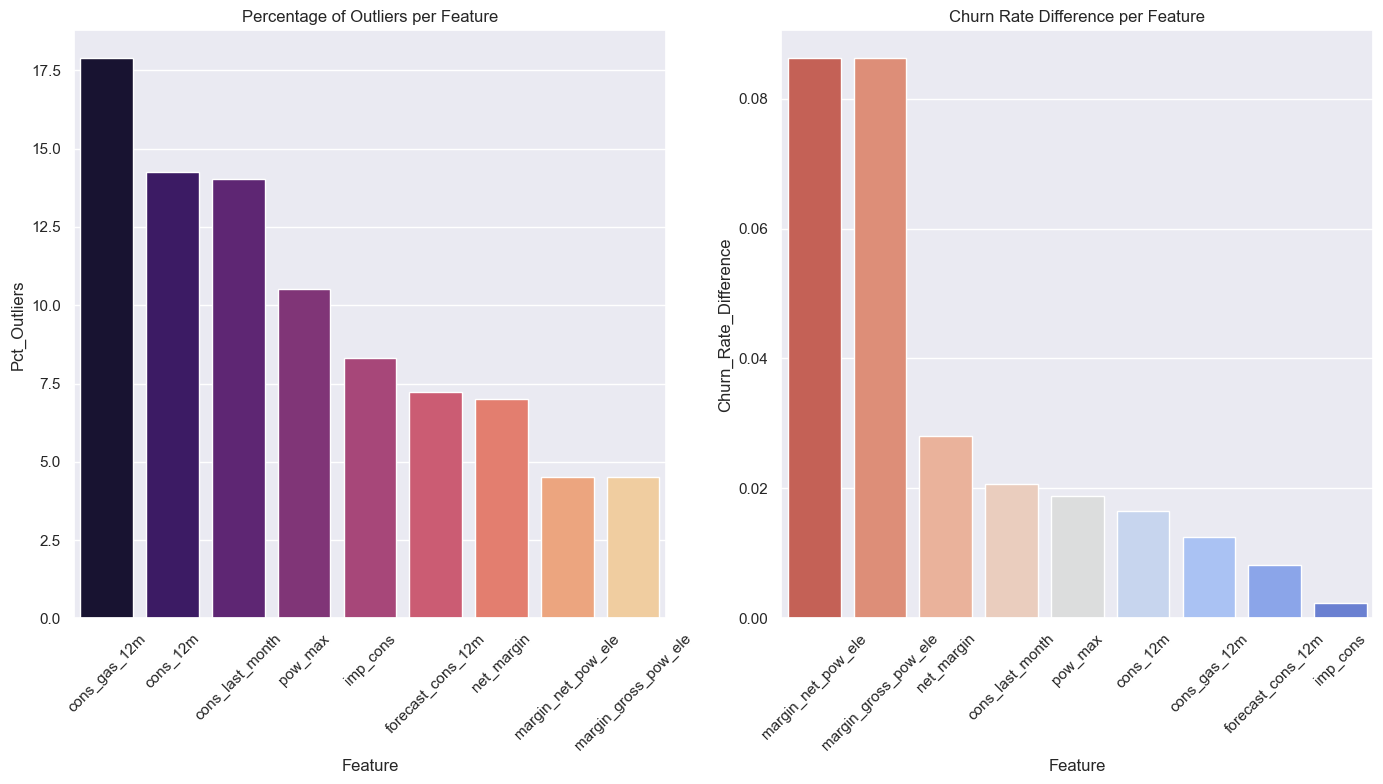

In [47]:
fig, axes = plt.subplots(1, 2, figsize=(14, 8))

# Plot 1: Percentage of Outliers per Feature
sns.barplot(x='Feature', y='Pct_Outliers', 
            data=outlier_result_df.sort_values('Pct_Outliers', ascending=False), 
            hue='Feature', palette='magma', ax=axes[0], legend=False)
axes[0].set_title('Percentage of Outliers per Feature')
axes[0].tick_params(axis='x', rotation=45)

# Plot 2: Churn Rate Difference per Feature
sns.barplot(x='Feature', y='Churn_Rate_Difference', 
            data=outlier_result_df.sort_values('Churn_Rate_Difference', ascending=False), 
            hue='Feature', palette='coolwarm_r', ax=axes[1], legend=False)
axes[1].set_title('Churn Rate Difference per Feature')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

The above visualization highlights key features where outliers significantly affect churn rates.

**Highlights**: 
1. **High Impact on Churn:**
   - **Features:** `margin_net_pow_ele` and `margin_gross_pow_ele`
   - **Context:** This implies that extreme values in these features significantly influence customer behavior.
   - **Action:** Prioritize cleaning these features by removing the outlier.

2. **Moderate Impact:**
   - **Features:** `net_margin` and `cons_last_month`
   - **Context:** This suggest that extreme financial and recent consumption behaviors are linked to higher churn although the impact is moderate
   - **Action:** Address outliers here to refine retention strategies, focusing on customers facing recent financial or consumption challenges.

3. **Lower Impact:**
   - **Features:** `cons_12m`, `cons_gas_12m`, `forecast_cons_12m`, `imp_cons`
   - **Context:** While outliers in these features may impact churn, the effect is less pronounced.
   - **Action:** Basic outlier treatment is sufficient; prioritize more impactful features for deeper cleaning.



#### Treating Outliers

1. For high-impact features (margin_net_pow_ele, margin_gross_pow_ele, net_margin), we remove extreme outliers to significantly reduce their influence on churn prediction.
2. For cons_last_month, which has a moderate impact, we cap the outliers at the 1st and 99th percentiles.
3. For lower-impact consumption-related features (cons_12m, cons_gas_12m, forecast_cons_12m, imp_cons), we apply a log transformation. This helps to reduce the impact of outliers while preserving more of the original data distribution.

In [35]:
def treat_outliers(df, column, lower_percentile=0.01, upper_percentile=0.99, method='cap'):
    lower = df[column].quantile(lower_percentile)
    upper = df[column].quantile(upper_percentile)
    
    if method == 'remove':
        df = df[(df[column] >= lower) & (df[column] <= upper)]
    elif method == 'cap':
        df.loc[df[column] < lower, column] = lower
        df.loc[df[column] > upper, column] = upper
    elif method == 'log':
        df[column] = np.log1p(df[column] - min(0, df[column].min()) + 1)
    
    return df

# Define treatment strategy for each column
treatment_strategy = {
    'margin_net_pow_ele': 'remove',
    'margin_gross_pow_ele': 'remove',
    'net_margin': 'remove',
    'cons_last_month': 'cap',
    'cons_12m': 'log',
    'cons_gas_12m': 'log',
    'forecast_cons_12m': 'log',
    'imp_cons': 'log'
}

# Treat outliers for each column
for column, method in treatment_strategy.items():
    client_df = treat_outliers(client_df, column, method=method)

# For other numeric columns not specified, apply a basic cap
other_numeric_columns = ['forecast_cons_year', 'forecast_discount_energy', 'forecast_meter_rent_12m',
                         'forecast_price_energy_off_peak', 'forecast_price_energy_peak',
                         'forecast_price_pow_off_peak', 'num_years_antig', 'pow_max']

for column in other_numeric_columns:
    client_df = treat_outliers(client_df, column, method='cap')

print("Outlier treatment completed.")

Outlier treatment completed.


C:\Users\ASUS TUF\AppData\Local\Temp\ipykernel_8132\1847198364.py:9: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '9836.999999999978' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[df[column] > upper, column] = upper


---

## 5. Exploratory Data analysis


In [11]:
def plot_stacked_bars(dataframe, title_, size_=(18, 10), rot_=0, legend_="upper right"):
    """
    Plot stacked bars with annotations
    """
    ax = dataframe.plot(
        kind="bar",
        stacked=True,
        figsize=size_,
        rot=rot_,
        title=title_
    )

    # Annotate bars
    annotate_stacked_bars(ax, textsize=14)
    # Rename legend
    plt.legend(["Retention", "Churn"], loc=legend_)
    # Labels
    plt.ylabel("Company base (%)")
    plt.show()

def annotate_stacked_bars(ax, pad=0.99, colour="white", textsize=13):
    """
    Add value annotations to the bars
    """

    # Iterate over the plotted rectanges/bars
    for p in ax.patches:
        
        # Calculate annotation
        value = str(round(p.get_height(),1))
        # If value is 0 do not annotate
        if value == '0.0':
            continue
        ax.annotate(
            value,
            ((p.get_x()+ p.get_width()/2)*pad-0.05, (p.get_y()+p.get_height()/2)*pad),
            color=colour,
            size=textsize
        )

def plot_distribution(dataframe, column, ax, bins_=50):
    """
    Plot variable distirbution in a stacked histogram of churned or retained company
    """
    # Create a temporal dataframe with the data to be plot
    temp = pd.DataFrame({"Retention": dataframe[dataframe["churn"]==0][column],
    "Churn":dataframe[dataframe["churn"]==1][column]})
    # Plot the histogram
    temp[["Retention","Churn"]].plot(kind='hist', bins=bins_, ax=ax, stacked=True)
    # X-axis label
    ax.set_xlabel(column)
    # Change the x-axis to plain style
    ax.ticklabel_format(style='plain', axis='x')

### Churn Distribution

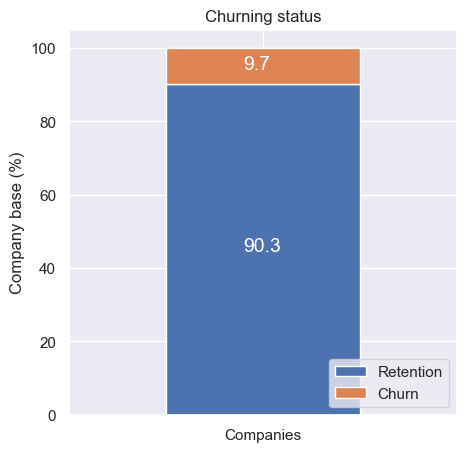

In [12]:
churn = client_df[['id', 'churn']]
churn.columns = ['Companies', 'churn']
churn_total = churn.groupby(churn['churn']).count()
churn_percentage = churn_total / churn_total.sum() * 100
plot_stacked_bars(churn_percentage.transpose(), "Churning status", (5, 5), legend_="lower right")

### Consumption

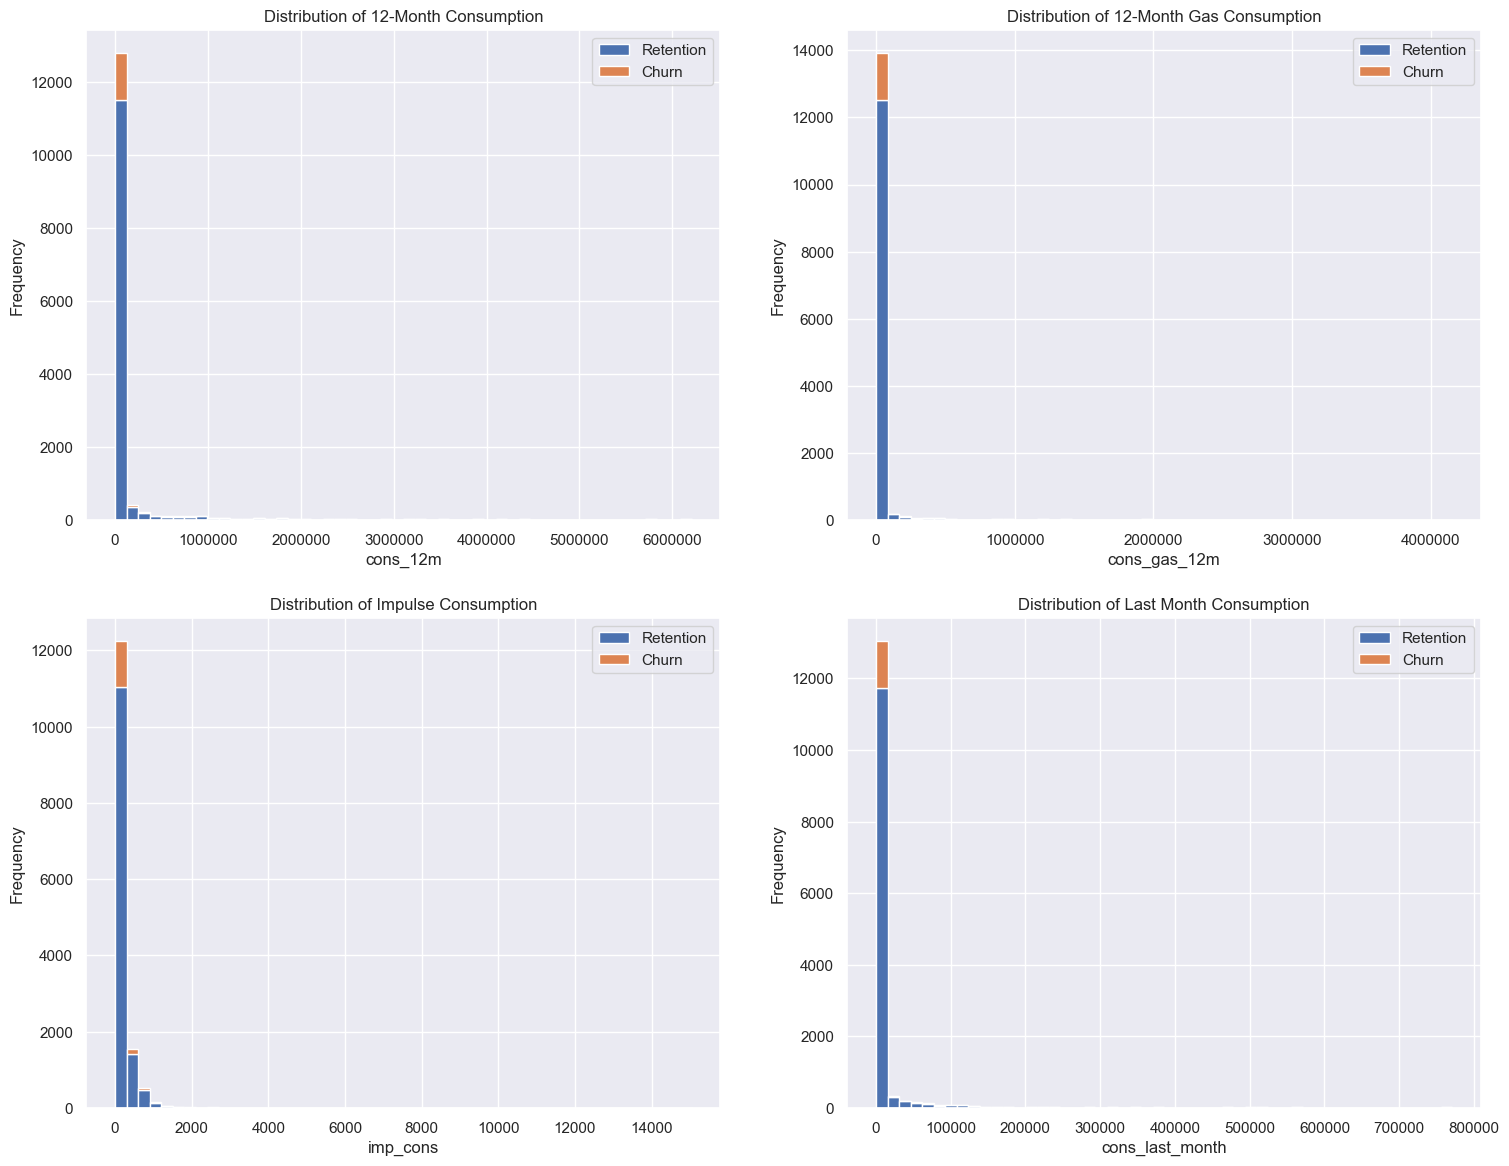

In [23]:
consumption = client_df[['id', 'cons_12m', 'cons_gas_12m', 'cons_last_month', 'imp_cons', 'has_gas', 'churn']]

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(18, 14))

# Adjusted title for each column
axs[0, 0].set_title('Distribution of 12-Month Consumption')
plot_distribution(consumption, 'cons_12m', axs[0, 0])

axs[0, 1].set_title('Distribution of 12-Month Gas Consumption')
plot_distribution(consumption, 'cons_gas_12m', axs[0, 1])

axs[1, 0].set_title('Distribution of Impulse Consumption')
plot_distribution(consumption, 'imp_cons', axs[1, 0])

axs[1, 1].set_title('Distribution of Last Month Consumption')
plot_distribution(consumption, 'cons_last_month', axs[1, 1])

### Client Information

#### Sales Channel

### Client Antiquity

#### Distribution of Client Antiquity

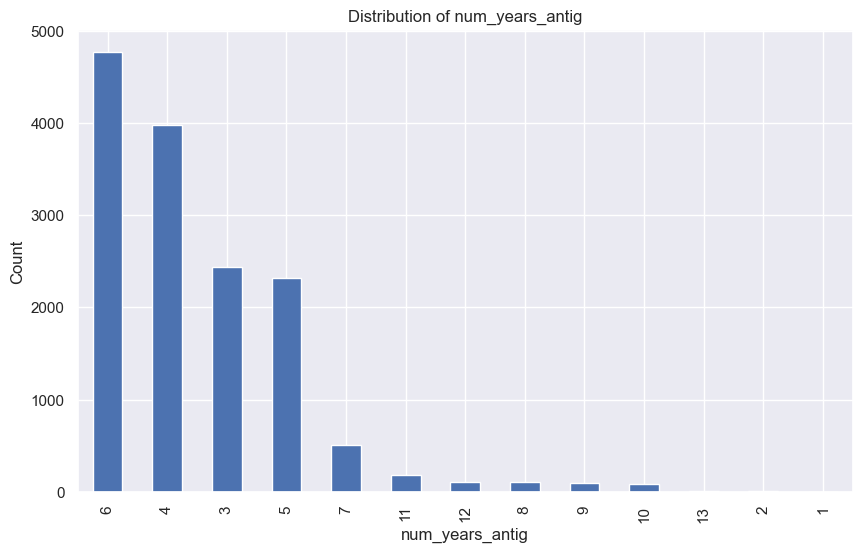

In [42]:
def plot_distribution(df, column_name, title):
    fig, ax = plt.subplots(figsize=(10, 6))
    df[column_name].value_counts().plot(kind='bar', ax=ax)
    ax.set_xlabel(column_name)
    ax.set_ylabel('Count')
    ax.set_title(title)

plot_distribution(client_df, 'num_years_antig', 'Distribution of num_years_antig')


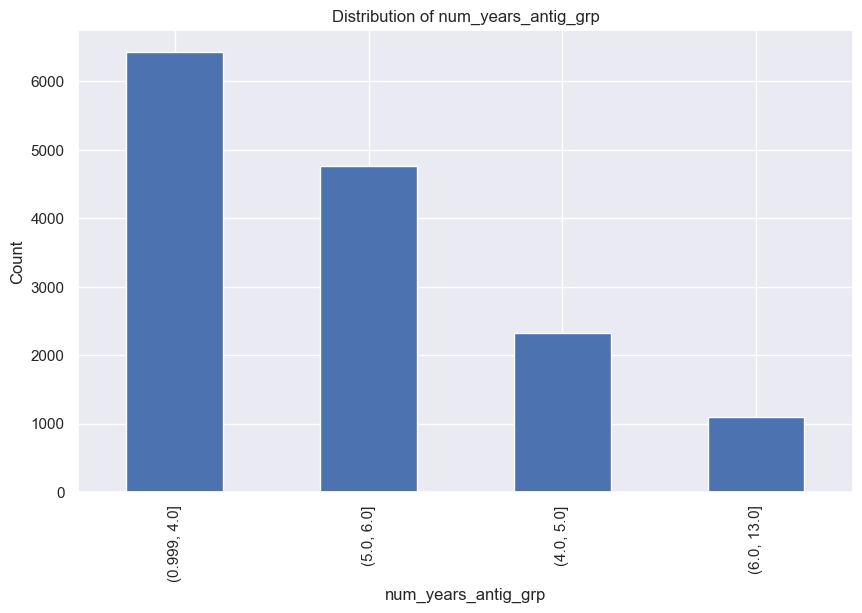

In [43]:
plot_distribution(client_df, 'num_years_antig_grp', 'Distribution of num_years_antig_grp')

### Tendency of Churn by Antiquity of Client

#### Hypothesis Testing

To better understand the factors influencing churn, we'll examine if there's a significant relationship between the length of time a customer has been with the company (`num_years_antig`) and their likelihood of churning. 

Specifically, we'll conduct a two-sample t-test to determine if there's a statistically significant difference in the average `num_years_antig` between customers who churned and those who did not. This analysis will help us determine if customer tenure is a potential predictor of churn. 

**Null Hypothesis:** There is no difference in the mean `num_years_antig` between customers who churned and those who did not.

**Alternative Hypothesis:**  There is a difference in the mean `num_years_antig` between customers who churned and those who did not.

Let's proceed with the t-test and interpret the results.



In [55]:
import numpy as np
from scipy.stats import ttest_ind

# Conduct a statistical test to examine the relationship between num_years_antig and churn

# Split the data into two groups based on the churn variable
churn_0 = client_df[client_df['churn'] == 0]['num_years_antig']
churn_1 = client_df[client_df['churn'] == 1]['num_years_antig']

# Perform a two-sample t-test to compare the means of num_years_antig between the two groups
t_stat, p_val = ttest_ind(churn_0, churn_1)

# Calculate the means and standard deviations for each group
mean_0 = churn_0.mean()
mean_1 = churn_1.mean()
std_0 = churn_0.std()
std_1 = churn_1.std()

# Calculate Cohen's d (effect size)
n0, n1 = len(churn_0), len(churn_1)
pooled_std = np.sqrt(((n0 - 1) * std_0**2 + (n1 - 1) * std_1**2) / (n0 + n1 - 2))
cohen_d = (mean_0 - mean_1) / pooled_std

# Print the results
print(f'T-statistic: {t_stat}')
print(f'p-value: {p_val}')
print(f'Cohen\'s d (effect size): {cohen_d}')

# Interpret the results
if p_val < 0.05:
    print('Reject the null hypothesis: There is a statistically significant difference in the means of num_years_antig between the two groups.')
else:
    print('Fail to reject the null hypothesis: There is no statistically significant difference in the means of num_years_antig between the two groups.')

# Interpret the effect size
if abs(cohen_d) < 0.2:
    effect_size_interpretation = "small"
elif abs(cohen_d) < 0.5:
    effect_size_interpretation = "medium"
elif abs(cohen_d) < 0.8:
    effect_size_interpretation = "large"
else:
    effect_size_interpretation = "very large"

print(f'Effect size interpretation: The effect size is {effect_size_interpretation}.')


T-statistic: 8.58502938912635
p-value: 1.00172784285285e-17
Cohen's d (effect size): 0.2465497527056532
Reject the null hypothesis: There is a statistically significant difference in the means of num_years_antig between the two groups.
Effect size interpretation: The effect size is medium.


The results indicate a statistically significant difference in the means of num_years_antig between the two groups (churn vs. no churn), with a p-value far below the standard significance level of 0.05. This means that the difference in tenure between customers who churned and those who did not is unlikely to have occurred by chance.

Additionally, the effect size (Cohen's d) of 0.25 suggests that the difference in tenure between the two groups, while statistically significant, is of a medium magnitude. This indicates that tenure does play a role in customer churn, though the impact is moderate.

The t-test results strongly indicate that there is a statistically significant difference in the average number of years as a customer (`num_years_antig`) between customers who churned and those who didn't. 

* **Highly Significant p-value:** The p-value of 2.92e-19 is extremely small (much less than the typical significance level of 0.05). This means that the probability of observing such a large difference in means by random chance alone is practically zero if there was truly no difference in the populations.

* **Rejecting the Null Hypothesis:**  Therefore, we reject the null hypothesis that there's no difference in the means of `num_years_antig` between churned and non-churned customers.

**Business Implication:**

This finding suggests that customer tenure (`num_years_antig`) is a significant factor related to churn. In simpler terms, how long a customer has been with the company appears to be associated with their likelihood of churning. 

**Next Step:**

* **Examine the direction of the relationship:** While the t-test tells us there's a difference, it doesn't indicate the direction.  Looking at the means of `num_years_antig` for each group (churned vs. non-churned) will reveal whether churned customers tend to have a *shorter* or *longer* average tenure.



#### Median of Antiquity of Client by Churn Status

In [78]:
median_antig_churn_0 = churn_0['num_years_antig'].median()
median_antig_churn_1 = churn_1['num_years_antig'].median()

print(f"Median num_years_antig for non-churned customers: {median_antig_churn_0:.2f}")
print(f"Median num_years_antig for churned customers: {median_antig_churn_1:.2f}")

Median num_years_antig for non-churned customers: 5.00
Median num_years_antig for churned customers: 4.00


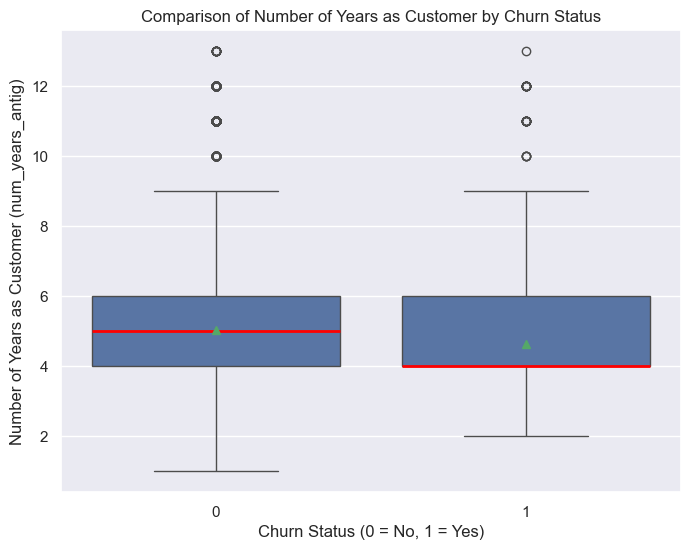

In [81]:
plt.figure(figsize=(8, 6)) 
sns.boxplot(x='churn', y='num_years_antig', data=client_df, showmeans=True, 
            medianprops={'color':'red', 'linewidth': 2})  # Customize median line
plt.title('Comparison of Number of Years as Customer by Churn Status')
plt.xlabel('Churn Status (0 = No, 1 = Yes)')
plt.ylabel('Number of Years as Customer (num_years_antig)')
plt.show()

# --- Direction Interpretation (from medians) ---
if median_antig_churn_0 > median_antig_churn_1:
    print("The box plot visually confirms that non-churned customers tend to have a longer median tenure.")
else:
    print("The box plot visually confirms that churned customers tend to have a shorter median tenure.")

#### Investigating the Direction of the Effect of Customer Tenure on Churn Risk

In [107]:
churn_prob = (client_df.groupby('num_years_antig_grp')['churn'].mean()
                  .reset_index())
churn_prob.columns = churn_prob.columns.str.replace('churn', 'churn_prob')
churn_prob['percent_decrease'] = churn_prob['churn_prob'].pct_change() * 100

# Assign churn_prob directly to client_df
client_df = client_df.merge(churn_prob, on='num_years_antig_grp')

C:\Users\ASUS TUF\AppData\Local\Temp\ipykernel_11844\3994708563.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  churn_prob = (client_df.groupby('num_years_antig_grp')['churn'].mean()


In [108]:
churn_prob

,num_years_antig_grp,churn_prob,percent_decrease
0,"(0.999, 4.0]",0.125097,NaN
1,"(4.0, 5.0]",0.086319,-30.998868
2,"(5.0, 6.0]",0.071084,-17.649088
3,"(6.0, 13.0]",0.069533,-2.181487


The analysis reveals a clear relationship between a client's antiquity (the length of time they've been a customer) and the probability of them churning. As client antiquity increases, the likelihood of churn steadily decreases. 

This trend is visualized in the accompanying chart, with a steep drop in churn probability observed between clients in their first four years compared to those who have stayed with the company for longer durations. Specifically, the most significant decrease (-31%) occurs when comparing the newest client group (0.99 - 4 years) to those who have been customers between 4 and 5 years. This suggests that retaining customers beyond the initial years is crucial for minimizing churn and highlights the importance of implementing strategies that encourage long-term customer loyalty.

d:\DS_Project\BCG_DataScience_VI\utils.py:38: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  v = v.replace(bin_dict)
d:\DS_Project\BCG_DataScience_VI\utils.py:130: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(['']+['(' + str(round(float(i.split(',')[0][1:]))) + ', ' + str(round(float(i.split(',')[1][:-1]))) + ']' for i in x_bins])


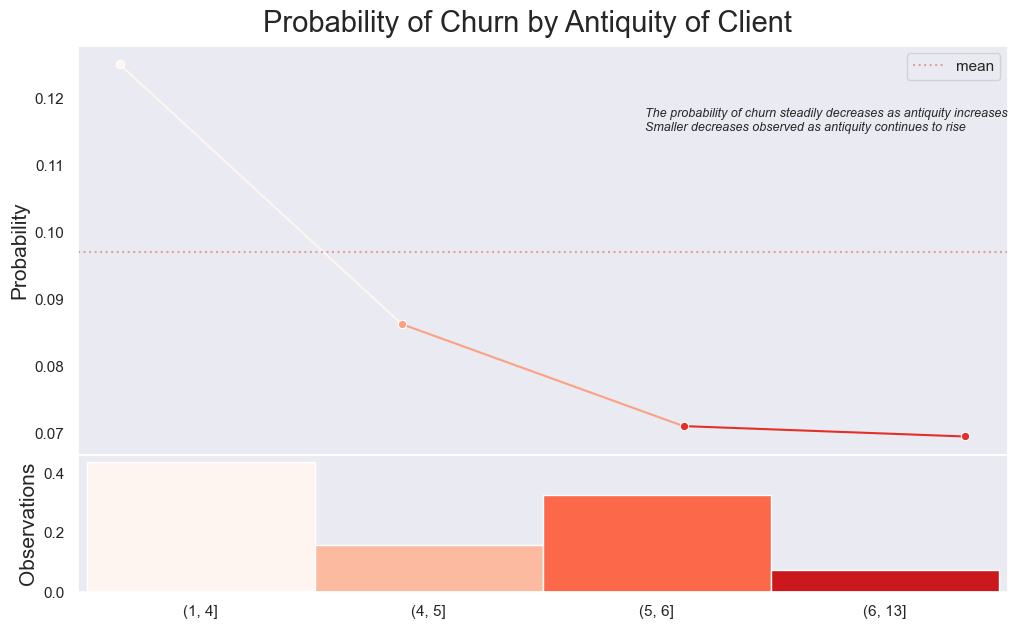

In [46]:
plot_prob_progression(client_df['num_years_antig'].dropna().reset_index(drop=True),
                      client_df['churn'].dropna().reset_index(drop=True),
                      x_intervals=4, use_quartiles=True,  mean_line=True,
                      title='Probability of Churn by Antiquity of Client',
                      text="The probability of churn steadily decreases as antiquity increases\nSmaller decreases observed as antiquity continues to rise")
     

This plot reveals a clear inverse relationship between customer tenure (antiquity) and churn probability:
1. New customers have the highest churn risk, with probabilities around 25-30%.
2. Churn probability decreases rapidly in the first few years of the customer relationship.
3. Long-term customers (highest antiquity) have the lowest churn risk, below 10%.
4. The rate of decrease in churn probability slows down for very long-term customers.

These findings suggest that retention efforts should be particularly focused on newer customers, as the risk of churn decreases significantly with increased tenure.

#### Quantifying the Impact of Customer Tenure on Churn Probability: A Logistic Regression Analysis

To further understand the impact of tenure on the likelihood of churn, a logistic regression model was employed. The logistic regression approach allows us to quantify the relationship between tenure (num_years_antig) and the probability of churn, while controlling for other factors.
 
The logistic regression model estimates coefficients that represent the change in the log odds of churn for a one-unit increase in the predictor variable, num_years_antig. By analyzing these coefficients, we can quantify the impact of customer tenure on churn probability.
 
Additionally, we calculate the odds ratio, which provides a more interpretable measure of the effect size. The odds ratio indicates the change in the odds of churn for a one-unit increase in customer tenure.

In [54]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, r2_score

# Prepare the data
X = client_df[['num_years_antig']]
y = client_df['churn']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and train the logistic regression model
model = LogisticRegression()
model.fit(X_train, y_train)

# Evaluate the model's performance
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
r_squared = r2_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")
print(f"R-squared: {r_squared:.4f}")

# Interpret the coefficients
print(f"Coefficient for num_years_antig: {model.coef_[0][0]:.4f}")

Accuracy: 0.8988
R-squared: -0.1126
Coefficient for num_years_antig: -0.1791


In [50]:
odds_ratio = np.exp(model.coef_[0][0])
print(f"Odds Ratio for num_years_antig: {odds_ratio:.4f}")

Odds Ratio for num_years_antig: 0.8361


The negative coefficient for tenure suggests that as the number of years a customer has been with the company increases, the likelihood of churn decreases. Specifically, the odds ratio of 0.8361 indicates that for each additional year of tenure, the odds of churn decrease by 16.39%. This means that customers who stay with the company for longer periods are significantly less likely to churn compared to newer customers.

#### Financial Implications

In [57]:
# Calculate the number of customers
num_customers = len(client_df)
print(f"Number of Customers: {num_customers}")

# Calculate average annual revenue per customer
avg_annual_revenue = client_df['net_margin'].mean()
print(f"Average Annual Revenue per Customer: {avg_annual_revenue:.2f}")

# Calculate total annual revenue
total_annual_revenue = client_df['net_margin'].sum()
print(f"Total Annual Revenue: {total_annual_revenue:.2f}")


Number of Customers: 14171
Average Annual Revenue per Customer: 172.91
Total Annual Revenue: 2450316.54


### Financial and Strategic Impact of Reducing Customer Churn

**Number of Customers**: 14,171  
**Average Annual Revenue per Customer**: $172.91
**Total Annual Revenue**: $2,450,300.61   
**Assumptions**:
- Profit Margin: 20%
- Customer Acquisition Cost: 1.5 times the annual revenue per customer.

#### Financial Implications

a) **Revenue Impact**  
For each additional year a customer is retained, the expected revenue increase per customer is calculated as follows:
- **Expected additional revenue per year retained**:  
  $172.91 * 0.1639 = **$28.34** per customer per year.

b) **Lifetime Value Increase**  
Assuming an average customer lifespan of 5 years, the increase in lifetime value due to the extended retention is:
- **Lifetime value increase**:  
  $28.34 * 5 = **$141.70** per customer.

c) **Profit Impact**  
With a 20% profit margin, the additional profit generated from each year of retention is:
- **Annual profit increase**:  
  $28.34 * 0.20 = **$5.67** per customer per year.  
- **Total profit increase over 5 years**:  
  $5.67 * 5 = **$28.35** additional profit per customer.

d) **Return on Retention Investment (ROI)**  
- **Estimated customer acquisition cost**:  
  $172.91 * 1.5 = **$259.37** per customer.
- **Investment in retention efforts**:  
  If 25% of the acquisition cost is reinvested in retention efforts per customer, it amounts to $64.84.
- **ROI over 5 years**:  
  ROI = ($141.70 - $64.84) / $64.84 = **118.54%**.

#### Strategic Implications

a) **Early Customer Focus**  
By focusing on reducing first-year churn by 10%, the financial benefits can be significant:
- **Additional retained customers**:  
  14,171 * 0.10 = **1,417 customers**.
- **Financial benefit**:  
  1,417 * $141.70 = **$200,788.90** in additional lifetime value.

b) **Loyalty Program Investment**  
Investing $20 per customer annually in a loyalty program over 5 years yields the following:
- **Total cost over 5 years**:  
  $20 * 5 = **$100** per customer.
- **Expected return**:  
  $141.70 per customer.
- **Net benefit**:  
  $141.70 - $100 = **$41.70** per customer.
- **Company-wide net benefit**:  
  14,171 * $41.70 = **$590,930.70** over 5 years.

#### Long-Term Business Impact

Reducing the overall churn rate by 5% through tenure-focused strategies leads to:
- **Additional retained customers**:  
  14,171 * 0.05 = **709 customers**.
- **Additional lifetime value**:  
  709 * $141.70 = **$100,465.30**.
- **Additional profit**:  
  $100,465.30 * 0.20 = **$20,093.06**.

#### Total Company-Wide Impact

- **Current annual revenue**:  
  14,171 * $172.91 = **$2,450,300.61**.
- **Potential additional annual revenue from a 5% churn reduction**:  
  709 * $172.91 = **$122,593.19**.
- **Percentage increase in annual revenue**: **5%**.

These findings demonstrate that targeted retention strategies focusing on reducing churn, particularly in the early stages of customer relationships, can substantially increase both revenue and profitability. Investing in loyalty programs and other retention efforts not only improves customer lifetime value but also delivers a strong return on investment, reinforcing the business's long-term sustainability and growth.